INHERENT LIMITATIONS for SRCNN


pre-processing step, the original LR image needs to be upsampled to the
desired size using bicubic interpolation to form the input. Thus the computation complexity of SRCNN grows quadratically with the spatial size of the HR image 
For the upscaling factor n, the computational cost of convolution
with the interpolated LR image will be n**2
times of that for the original LR one


second restriction lies on the costly non-linear mapping step. In SRCNN, input
image patches are projected on a high-dimensional LR feature space, then followed by
a complex mapping to another high-dimensional HR feature space. Dong et al. [2] show
that the mapping accuracy can be substantially improved by adopting a wider mapping
layer, but at the cost of the running time. For example, the large SRCNN (SRCNNEx) [2] has 57,184 parameters, which are six times larger than that for SRCNN (8,032
parameters). Then the question is how to shrink the network scale while still keeping
the previous accuracy.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random


In [2]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image



In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [4]:
root_dir = r"C:\Users\USER\Convolution\Task D\face2comics_v1.0.0_by_Sxela\face2comics_v1.0.0_by_Sxela\face"


dataset = ImageDataset(root_dir=root_dir, transform=transform)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Train size: 2560, Validation size: 320, Test size: 320


In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of images in Training set: {num_train_images}")
print(f"Number of images in Validation set: {num_val_images}")
print(f"Number of images in Test set: {num_test_images}")

Number of images in Training set: 2560
Number of images in Validation set: 320
Number of images in Test set: 320


In [8]:
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in Training set: {num_train_batches}") 
print(f"Number of batches in Validation set: {num_val_batches}")
print(f"Number of batches in Test set: {num_test_batches}")

Number of batches in Training set: 160
Number of batches in Validation set: 20
Number of batches in Test set: 20


In [9]:
class FSRCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 56, kernel_size = 5, padding = 2)
        self.conv_2 = nn.Conv2d(in_channels = 56, out_channels = 12, kernel_size = 1, padding = 0)
        self.conv_3 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, padding = 1)
        self.conv_4 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, padding = 1)
        self.conv_5 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, padding = 1)
        self.conv_6 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, padding = 1)
        self.conv_7 = nn.Conv2d(in_channels = 12, out_channels = 56, kernel_size = 1, padding = 0)
        self.de_conv_1 = nn.ConvTranspose2d(in_channels = 56, out_channels = 3, kernel_size = 9, stride = 3, padding = 3, output_padding = 0)

    def forward(self, x):
        x1 = self.conv_1(x)
        x1 = F.relu(x1)
        x2 = self.conv_2(x1)
        x2 = F.relu(x2)
        x3 = self.conv_3(x2)
        x3 = F.relu(x3)
        x4 = self.conv_4(x3)
        x4 = F.relu(x4)
        x5 = self.conv_5(x4)
        x5 = F.relu(x5)
        x6 = self.conv_6(x5)
        x6 = F.relu(x6)
        x7 = self.conv_7(x6)
        output = self.de_conv_1(x7)
        output = F.relu(output)
        return output

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


model = FSRCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda


In [11]:
def calculate_metrics(output, target):
    # Resize the target to match the output size
    target_resized = F.interpolate(target, size=output.shape[2:], mode='bicubic', align_corners=False)
    
    output_np = output.squeeze().cpu().numpy()
    target_np = target_resized.squeeze().cpu().numpy()
    
    # Calculate SSIM, PSNR, and MSE
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5) for o, t in zip(output_np, target_np)])
    psnr_val = np.mean([psnr(t, o, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    
    return ssim_val, psnr_val, mse_val

In [12]:
def visualize_images(original,output):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original.cpu().permute(1, 2, 0).numpy())
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(output.cpu().permute(1, 2, 0).numpy())
    plt.title('Model Output')
    plt.axis('off')
    
    plt.show()

Epoch [1/70], Step [10/160], Loss: 0.0817
Epoch [1/70], Step [20/160], Loss: 0.0623
Epoch [1/70], Step [30/160], Loss: 0.0507
Epoch [1/70], Step [40/160], Loss: 0.0269
Epoch [1/70], Step [50/160], Loss: 0.0249
Epoch [1/70], Step [60/160], Loss: 0.0232
Epoch [1/70], Step [70/160], Loss: 0.0199
Epoch [1/70], Step [80/160], Loss: 0.0203
Epoch [1/70], Step [90/160], Loss: 0.0200
Epoch [1/70], Step [100/160], Loss: 0.0204
Epoch [1/70], Step [110/160], Loss: 0.0171
Epoch [1/70], Step [120/160], Loss: 0.0176
Epoch [1/70], Step [130/160], Loss: 0.0172
Epoch [1/70], Step [140/160], Loss: 0.0159
Epoch [1/70], Step [150/160], Loss: 0.0159
Epoch [1/70], Step [160/160], Loss: 0.0161
Validation - Epoch [1/70], SSIM: 0.7048, PSNR: 21.0267, MSE: 0.0146
Epoch [2/70], Step [10/160], Loss: 0.0162
Epoch [2/70], Step [20/160], Loss: 0.0142
Epoch [2/70], Step [30/160], Loss: 0.0174
Epoch [2/70], Step [40/160], Loss: 0.0152
Epoch [2/70], Step [50/160], Loss: 0.0162
Epoch [2/70], Step [60/160], Loss: 0.0151
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/70], Step [160/160], Loss: 0.0119


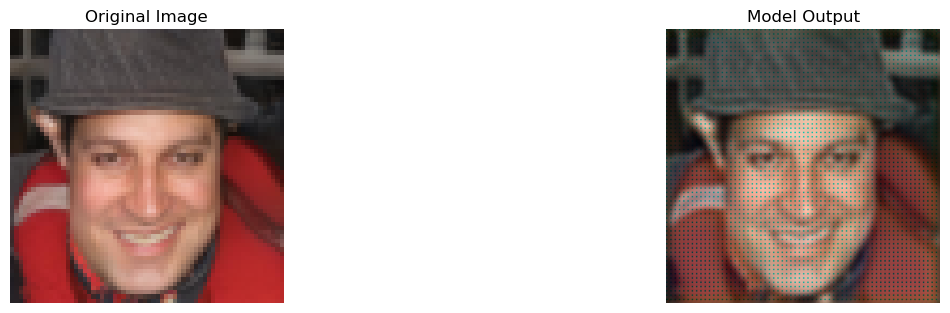

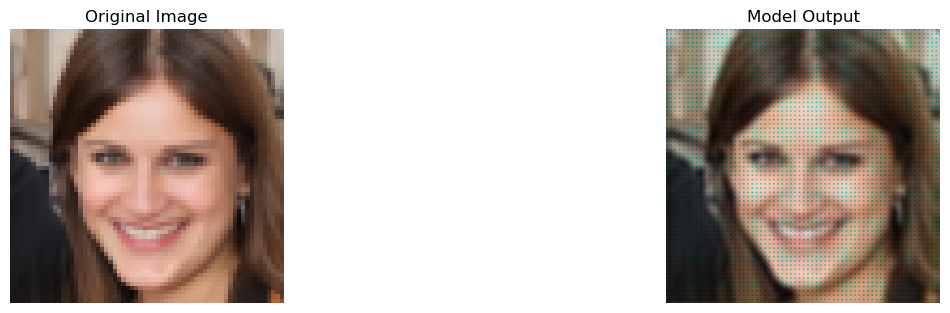

Validation - Epoch [10/70], SSIM: 0.8373, PSNR: 24.5791, MSE: 0.0126
Epoch [11/70], Step [10/160], Loss: 0.0126
Epoch [11/70], Step [20/160], Loss: 0.0130
Epoch [11/70], Step [30/160], Loss: 0.0125
Epoch [11/70], Step [40/160], Loss: 0.0139
Epoch [11/70], Step [50/160], Loss: 0.0109
Epoch [11/70], Step [60/160], Loss: 0.0129
Epoch [11/70], Step [70/160], Loss: 0.0120
Epoch [11/70], Step [80/160], Loss: 0.0111
Epoch [11/70], Step [90/160], Loss: 0.0031
Epoch [11/70], Step [100/160], Loss: 0.0011
Epoch [11/70], Step [110/160], Loss: 0.0007
Epoch [11/70], Step [120/160], Loss: 0.0004
Epoch [11/70], Step [130/160], Loss: 0.0005
Epoch [11/70], Step [140/160], Loss: 0.0003
Epoch [11/70], Step [150/160], Loss: 0.0003
Epoch [11/70], Step [160/160], Loss: 0.0002
Validation - Epoch [11/70], SSIM: 0.9577, PSNR: 35.2518, MSE: 0.0002
Epoch [12/70], Step [10/160], Loss: 0.0002
Epoch [12/70], Step [20/160], Loss: 0.0002
Epoch [12/70], Step [30/160], Loss: 0.0003
Epoch [12/70], Step [40/160], Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/70], Step [160/160], Loss: 0.0001


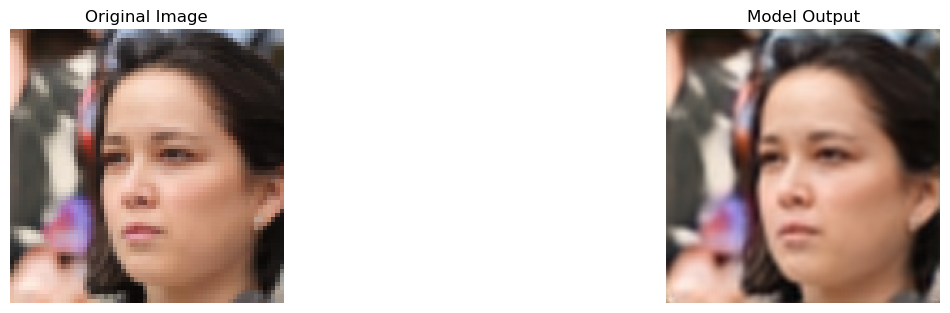

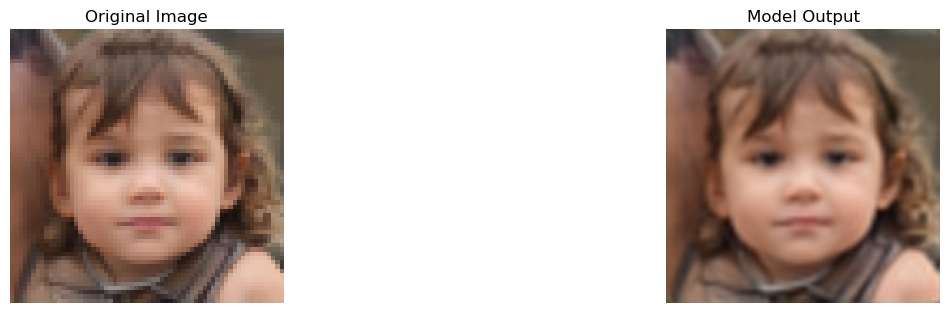

Validation - Epoch [20/70], SSIM: 0.9796, PSNR: 38.2080, MSE: 0.0001
Epoch [21/70], Step [10/160], Loss: 0.0001
Epoch [21/70], Step [20/160], Loss: 0.0002
Epoch [21/70], Step [30/160], Loss: 0.0001
Epoch [21/70], Step [40/160], Loss: 0.0001
Epoch [21/70], Step [50/160], Loss: 0.0002
Epoch [21/70], Step [60/160], Loss: 0.0002
Epoch [21/70], Step [70/160], Loss: 0.0001
Epoch [21/70], Step [80/160], Loss: 0.0001
Epoch [21/70], Step [90/160], Loss: 0.0002
Epoch [21/70], Step [100/160], Loss: 0.0002
Epoch [21/70], Step [110/160], Loss: 0.0001
Epoch [21/70], Step [120/160], Loss: 0.0001
Epoch [21/70], Step [130/160], Loss: 0.0001
Epoch [21/70], Step [140/160], Loss: 0.0001
Epoch [21/70], Step [150/160], Loss: 0.0003
Epoch [21/70], Step [160/160], Loss: 0.0002
Validation - Epoch [21/70], SSIM: 0.9811, PSNR: 36.8139, MSE: 0.0001
Epoch [22/70], Step [10/160], Loss: 0.0002
Epoch [22/70], Step [20/160], Loss: 0.0001
Epoch [22/70], Step [30/160], Loss: 0.0001
Epoch [22/70], Step [40/160], Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [30/70], Step [160/160], Loss: 0.0001


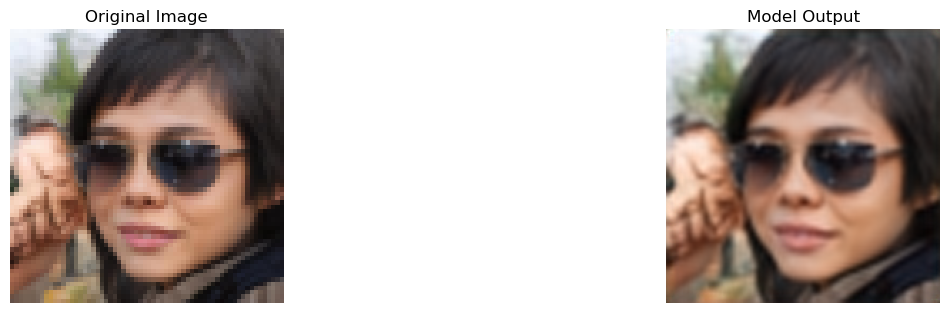

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


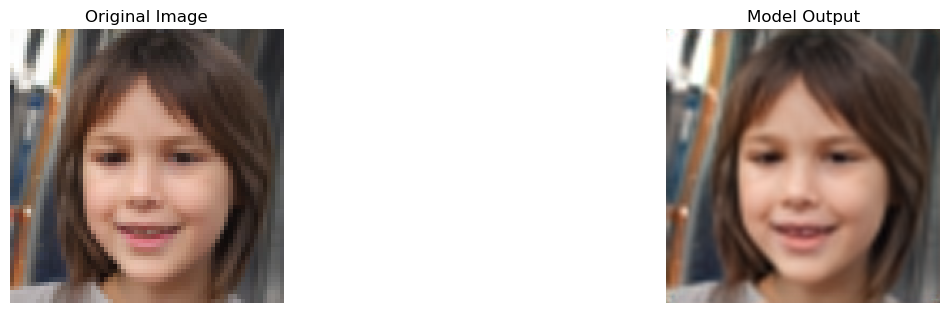

Validation - Epoch [30/70], SSIM: 0.9852, PSNR: 39.2726, MSE: 0.0001
Epoch [31/70], Step [10/160], Loss: 0.0001
Epoch [31/70], Step [20/160], Loss: 0.0026
Epoch [31/70], Step [30/160], Loss: 0.0007
Epoch [31/70], Step [40/160], Loss: 0.0002
Epoch [31/70], Step [50/160], Loss: 0.0001
Epoch [31/70], Step [60/160], Loss: 0.0002
Epoch [31/70], Step [70/160], Loss: 0.0002
Epoch [31/70], Step [80/160], Loss: 0.0001
Epoch [31/70], Step [90/160], Loss: 0.0001
Epoch [31/70], Step [100/160], Loss: 0.0001
Epoch [31/70], Step [110/160], Loss: 0.0001
Epoch [31/70], Step [120/160], Loss: 0.0001
Epoch [31/70], Step [130/160], Loss: 0.0001
Epoch [31/70], Step [140/160], Loss: 0.0001
Epoch [31/70], Step [150/160], Loss: 0.0001
Epoch [31/70], Step [160/160], Loss: 0.0001
Validation - Epoch [31/70], SSIM: 0.9845, PSNR: 39.9774, MSE: 0.0001
Epoch [32/70], Step [10/160], Loss: 0.0001
Epoch [32/70], Step [20/160], Loss: 0.0001
Epoch [32/70], Step [30/160], Loss: 0.0001
Epoch [32/70], Step [40/160], Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/70], Step [160/160], Loss: 0.0001


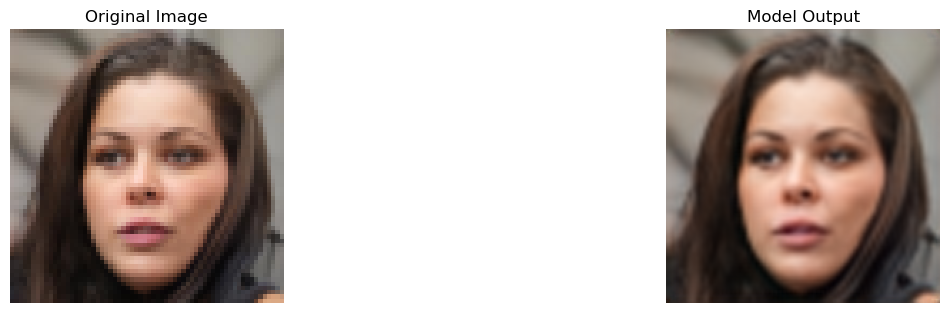

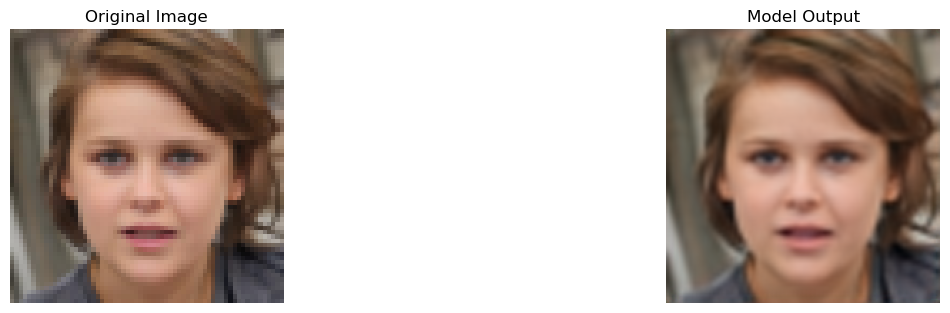

Validation - Epoch [40/70], SSIM: 0.9907, PSNR: 42.5390, MSE: 0.0000
Epoch [41/70], Step [10/160], Loss: 0.0001
Epoch [41/70], Step [20/160], Loss: 0.0001
Epoch [41/70], Step [30/160], Loss: 0.0001
Epoch [41/70], Step [40/160], Loss: 0.0001
Epoch [41/70], Step [50/160], Loss: 0.0001
Epoch [41/70], Step [60/160], Loss: 0.0001
Epoch [41/70], Step [70/160], Loss: 0.0001
Epoch [41/70], Step [80/160], Loss: 0.0002
Epoch [41/70], Step [90/160], Loss: 0.0001
Epoch [41/70], Step [100/160], Loss: 0.0001
Epoch [41/70], Step [110/160], Loss: 0.0001
Epoch [41/70], Step [120/160], Loss: 0.0001
Epoch [41/70], Step [130/160], Loss: 0.0001
Epoch [41/70], Step [140/160], Loss: 0.0001
Epoch [41/70], Step [150/160], Loss: 0.0001
Epoch [41/70], Step [160/160], Loss: 0.0001
Validation - Epoch [41/70], SSIM: 0.9903, PSNR: 42.2057, MSE: 0.0000
Epoch [42/70], Step [10/160], Loss: 0.0000
Epoch [42/70], Step [20/160], Loss: 0.0001
Epoch [42/70], Step [30/160], Loss: 0.0001
Epoch [42/70], Step [40/160], Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [50/70], Step [160/160], Loss: 0.0000


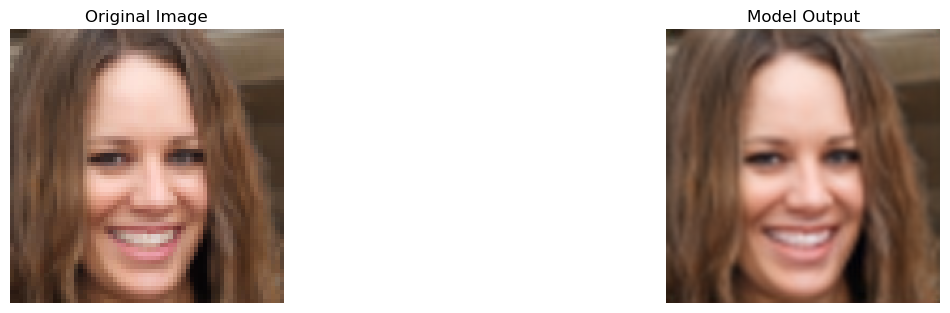

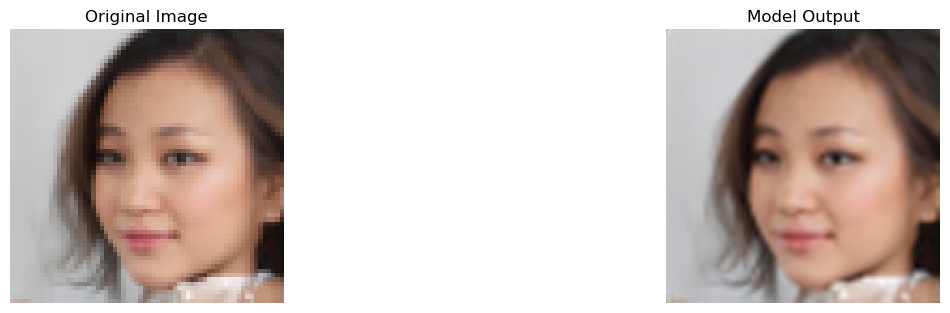

Validation - Epoch [50/70], SSIM: 0.9936, PSNR: 44.3245, MSE: 0.0000
Epoch [51/70], Step [10/160], Loss: 0.0001
Epoch [51/70], Step [20/160], Loss: 0.0001
Epoch [51/70], Step [30/160], Loss: 0.0000
Epoch [51/70], Step [40/160], Loss: 0.0000
Epoch [51/70], Step [50/160], Loss: 0.0000
Epoch [51/70], Step [60/160], Loss: 0.0001
Epoch [51/70], Step [70/160], Loss: 0.0000
Epoch [51/70], Step [80/160], Loss: 0.0001
Epoch [51/70], Step [90/160], Loss: 0.0002
Epoch [51/70], Step [100/160], Loss: 0.0003
Epoch [51/70], Step [110/160], Loss: 0.0001
Epoch [51/70], Step [120/160], Loss: 0.0001
Epoch [51/70], Step [130/160], Loss: 0.0001
Epoch [51/70], Step [140/160], Loss: 0.0001
Epoch [51/70], Step [150/160], Loss: 0.0000
Epoch [51/70], Step [160/160], Loss: 0.0000
Validation - Epoch [51/70], SSIM: 0.9901, PSNR: 42.3517, MSE: 0.0000
Epoch [52/70], Step [10/160], Loss: 0.0000
Epoch [52/70], Step [20/160], Loss: 0.0000
Epoch [52/70], Step [30/160], Loss: 0.0000
Epoch [52/70], Step [40/160], Loss: 0.

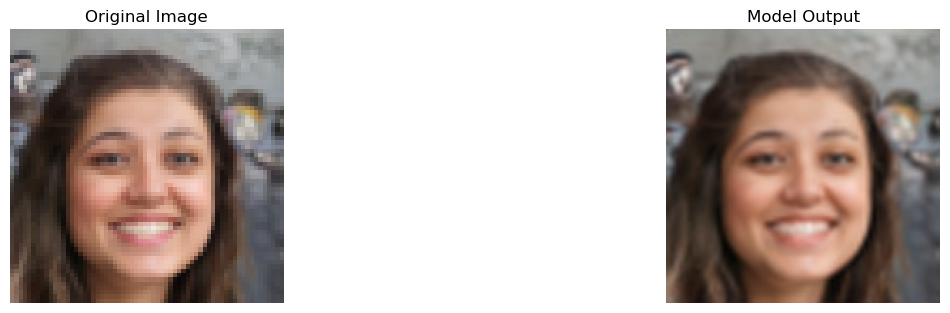

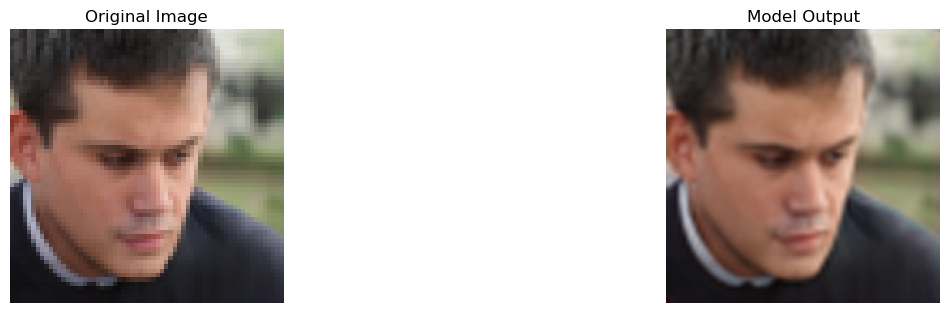

Validation - Epoch [60/70], SSIM: 0.9912, PSNR: 38.9921, MSE: 0.0001
Epoch [61/70], Step [10/160], Loss: 0.0001
Epoch [61/70], Step [20/160], Loss: 0.0001
Epoch [61/70], Step [30/160], Loss: 0.0000
Epoch [61/70], Step [40/160], Loss: 0.0001
Epoch [61/70], Step [50/160], Loss: 0.0000
Epoch [61/70], Step [60/160], Loss: 0.0000
Epoch [61/70], Step [70/160], Loss: 0.0000
Epoch [61/70], Step [80/160], Loss: 0.0000
Epoch [61/70], Step [90/160], Loss: 0.0000
Epoch [61/70], Step [100/160], Loss: 0.0000
Epoch [61/70], Step [110/160], Loss: 0.0000
Epoch [61/70], Step [120/160], Loss: 0.0001
Epoch [61/70], Step [130/160], Loss: 0.0000
Epoch [61/70], Step [140/160], Loss: 0.0001
Epoch [61/70], Step [150/160], Loss: 0.0000
Epoch [61/70], Step [160/160], Loss: 0.0000
Validation - Epoch [61/70], SSIM: 0.9931, PSNR: 43.0403, MSE: 0.0000
Epoch [62/70], Step [10/160], Loss: 0.0000
Epoch [62/70], Step [20/160], Loss: 0.0000
Epoch [62/70], Step [30/160], Loss: 0.0002
Epoch [62/70], Step [40/160], Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [70/70], Step [160/160], Loss: 0.0000


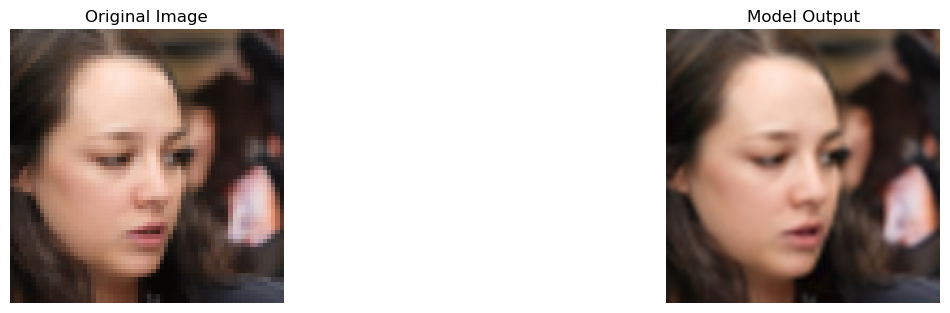

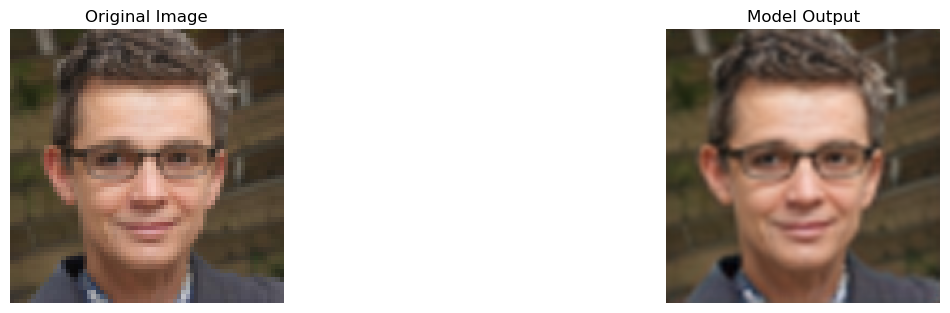

Validation - Epoch [70/70], SSIM: 0.9931, PSNR: 44.9247, MSE: 0.0000


: 

In [ ]:
num_epochs = 70
scale_factor = 3 

for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data.to(device)  
        outputs = model(inputs)  
        inputs_resized = F.interpolate(inputs, size=outputs.shape[2:], mode='bicubic', align_corners=False)
        loss = criterion(outputs, inputs_resized) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    

    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    selected_images = random.sample(range(len(val_loader.dataset)), k=2) 

    with torch.no_grad():
        for idx in selected_images:
            inputs = val_loader.dataset[idx].unsqueeze(0).to(device)
            outputs = model(inputs)

            inputs_resized = F.interpolate(inputs,scale_factor=scale_factor, mode='bicubic', align_corners=False)

            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs_resized)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

            if (epoch + 1) % 10 == 0:
                visualize_images(inputs[0],outputs[0])

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], SSIM: {ssim_total / len(selected_images):.4f}, '
          f'PSNR: {psnr_total / len(selected_images):.4f}, MSE: {mse_total / len(selected_images):.4f}')
